# Kelp Competition
1. 

## Data preparation

In [1]:
import os,sys
import glob
import re
import numpy as np
import pandas as pd
# CV tools
import tifffile as tiff
#Visulization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
# Pytorch
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from tqdm import *
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

In [2]:
# Mac OS
# device = "mps" if torch.backends.mps.is_available else "cpu"
# print(f"device is {device}")
# Windows
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cuda


### Set working directory

In [3]:
# Define your data and label folder paths
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'minidata')
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')
label_dir = os.path.join(data_dir, 'label')

temp_dir = [data_dir,train_dir,test_dir,label_dir]

for dir in temp_dir:
    if not os.path.exists(dir):
        os.makedirs(dir)

# for dirpath, dirnames, filenames in os.walk(data_dir):
#     for filename in filenames:
#         print(os.path.join(dirpath, filename))

In [4]:
test_dir

'c:\\Users\\guoyy\\OneDrive\\Desktop\\TESTING\\kelp\\minidata\\test'

In [5]:
pattern_train = train_dir + "/*.tif"
train_list = glob.glob(pattern_train)
pattern_test = test_dir + "/*.tif"
test_list = glob.glob(pattern_test)
pattern_label = label_dir + "/*.tif"

label_list = glob.glob(pattern_label)

In [6]:
type(label_list)

list

### Understand the dataset

In [7]:
image = tiff.imread("C:\\Users\\guoyy\\OneDrive\\Desktop\\TESTING\\kelp\\data\\train\\AA498489_satellite.tif")

# Get the shape of the image
shape = image.shape

print("Image shape:", shape)

Image shape: (350, 350, 7)


In [8]:
image = tiff.imread("C:\\Users\\guoyy\\OneDrive\\Desktop\\TESTING\\kelp\\data\\label\\AA498489_kelp.tif")


print("label image shape:", image.shape)
image_array = np.array(image)

# Find the unique values in the image
unique_values = np.unique(image_array)
print(unique_values)

label image shape: (350, 350)
[0 1]


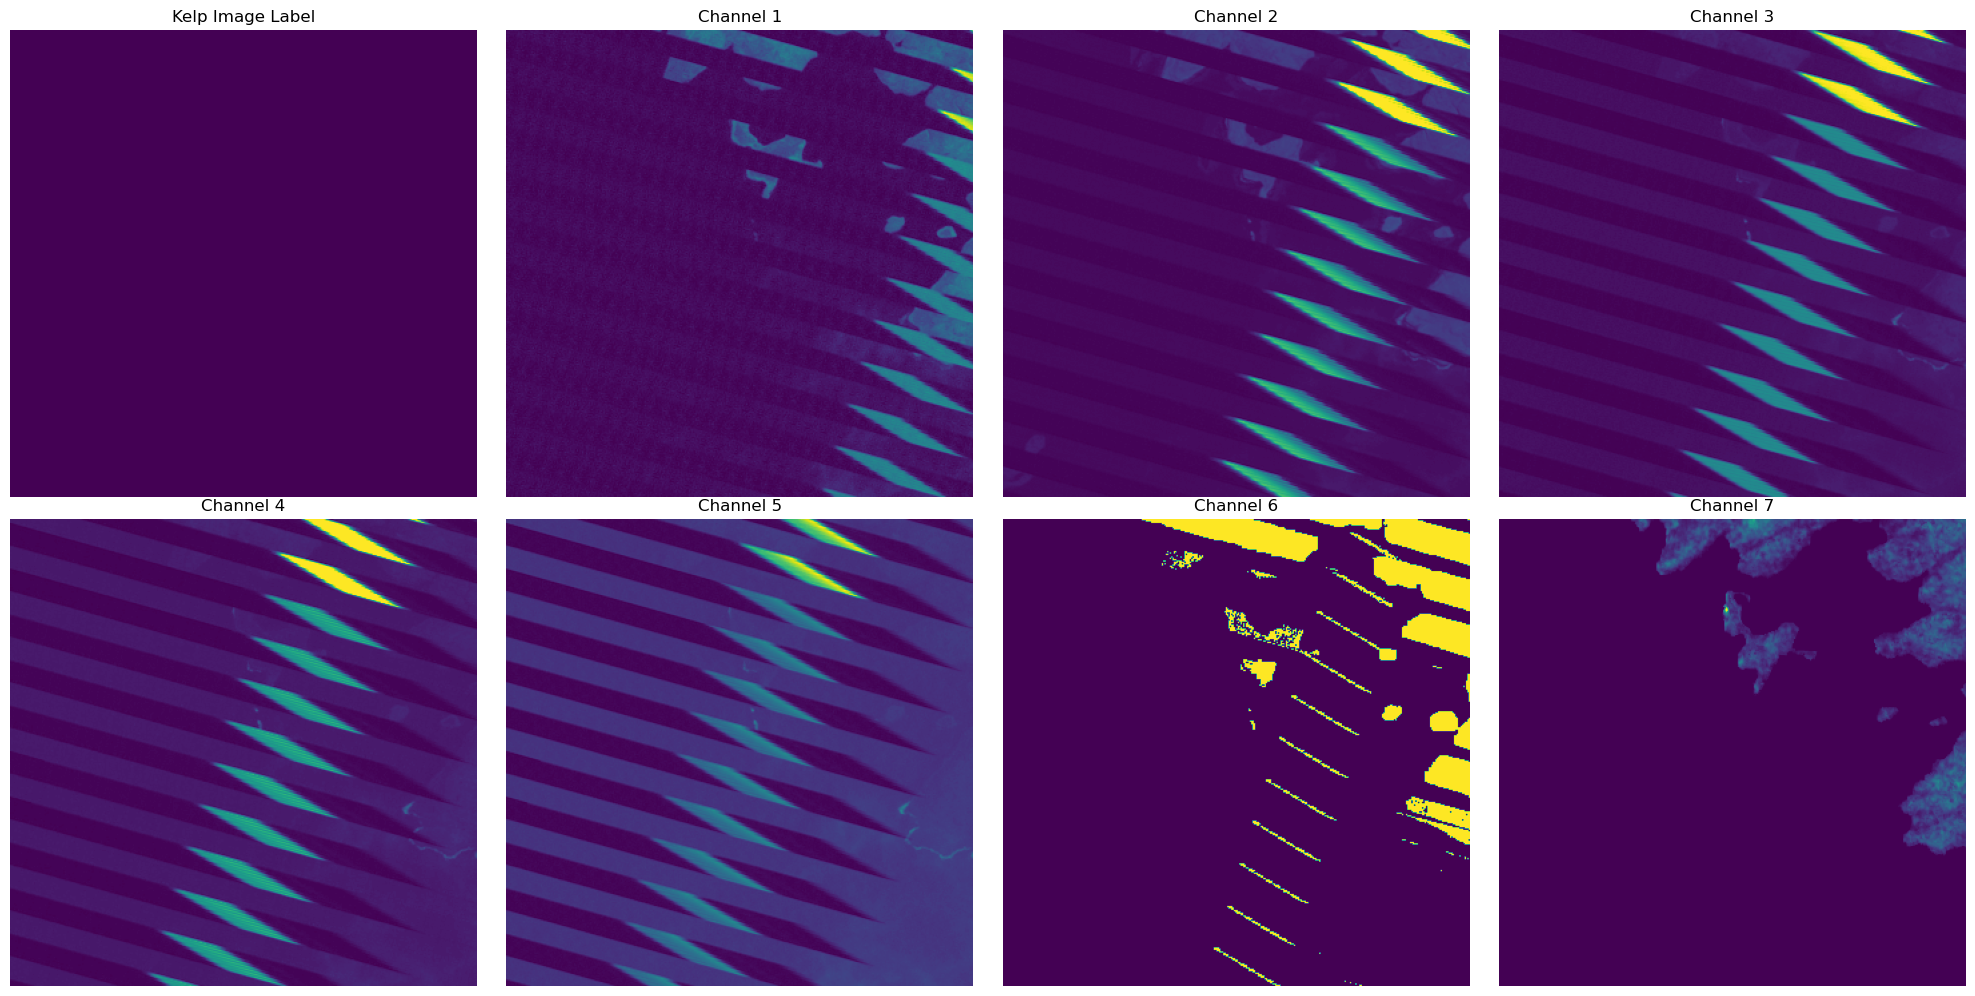

In [9]:
def tensor_transform(list):
    for image in list:
        with tiff.tifffile(image) as temp:
            temp.asarray




#  randomly print the map in training list
def show_image():
    n = 20
    with tiff.TiffFile(sorted(train_list)[n]) as train_temp:
        train = train_temp.asarray()
    with tiff.TiffFile(sorted(label_list)[n]) as label_temp:
        label = label_temp.asarray()

    n_channels = train.shape[2]

    plt.figure(figsize=(20, 10))  # Adjust the size as needed

    # Add the single image as the first subplot
    plt.subplot(2, 4, 1)  # Consider it's placed in a 2x4 grid
    plt.imshow(label)  # Assuming it's grayscale; adjust as needed
    plt.title('Kelp Image Label')
    plt.axis('off')

    # Loop through each channel of the satellite image and add as subsequent subplots
    for i in range(n_channels):
        plt.subplot(2, 4, i + 2)  # Offset by 2 to account for the first kelp image
        plt.imshow(train[:, :, i])  # Display each channel in grayscale
        plt.title(f'Channel {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    
show_image()

In [15]:
n = 23 #= np.random.randint(1,4509)
with tiff.TiffFile(sorted(train_list)[n]) as train_temp:
    train = train_temp.asarray()
with tiff.TiffFile(sorted(label_list)[n]) as label_temp:
    label = label_temp.asarray()

n_channels = train.shape[2]
layer_list = ["Short-wave infrared (SWIR)", "Near infrared (NIR)", "Red", "Green" ,"Blue" ,"Cloud Mask(binary - is there cloud or not)", "Digital Elevation Model (meters above sea-level)"]

plt.figure(figsize=(6, 6))  # Adjust the size as needed for each figure

# Display a channel from the satellite image
plt.imshow(label)  # Displaying the i-th channel
plt.title(f'the label')

# Overlay the label with transparency
plt.imshow(label, cmap='jet', alpha=0.2)  # 'cmap' and 'alpha' for the label can be adjusted based on preference

plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

for i in range(n_channels):
    plt.figure(figsize=(6, 6))  # Adjust the size as needed for each figure

    # Display a channel from the satellite image
    plt.imshow(train[:, :, i])  # Displaying the i-th channel
    plt.title(f'Channel {i+1} with {layer_list[i]}')

    # Overlay the label with transparency
    plt.imshow(label, cmap='jet', alpha=0.2)  # 'cmap' and 'alpha' for the label can be adjusted based on preference

    plt.axis('off')  # Hide axis
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv_block(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Input is CHW
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = ConvBlock(7, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.up1 = Up(512 + 256, 256)
        self.up2 = Up(256 + 128, 128)
        self.up3 = Up(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        skip1 = self.down1(x)
        skip2 = self.down2(skip1)
        skip3 = self.down3(skip2)
        x = self.down4(skip3)
        x = self.up1(x, skip3)
        x = self.up2(x, skip2)
        x = self.up3(x, skip1)


In [ ]:
from torchviz import make_dot

# Assuming `model` is your UNet model and `x` is your input tensor
output = model(x)

# Generate the graph. `params` argument combines model parameters and the input tensor
graph = make_dot(output, params=dict(list(model.named_parameters()) + [('input', x)]))

# Render the graph to a file (e.g., PNG format)
graph.render("path_to_output/unet_graph", format="png")

In [ ]:
def count_files_in_folder(folder):
    # Get list of filenames in the folder
    files = os.listdir(folder)
    
    # Count the number of files
    num_files = len(files)
    
    return num_files

# Example usage:
num_files_in_folder1 = count_files_in_folder(train_dir)
print(f"Number of files in training folder: {num_files_in_folder1}")
# Example usage:
num_files_in_folder1 = count_files_in_folder(label_dir)
print(f"Number of files in label folder: {num_files_in_folder1}")

Number of files in training folder: 5635
Number of files in label folder: 5635


In [ ]:
def compare_folders(folder1, folder2):
    # Get list of filenames in each folder
    files1 = sorted(os.listdir(folder1))
    files2 = sorted(os.listdir(folder2))
    
    for file1, file2 in zip(files1, files2):
        # Split filenames by underscore and compare the first part
        name1 = file1.split('_')[0]
        name2 = file2.split('_')[0]
        
        if name1 != name2:
            print(f"Files '{file1}' and '{file2}' have different prefixes.")
            return False
    
    print("All filenames in both folders have the same prefixes.")
    return True


compare_folders(train_dir, label_dir)

All filenames in both folders have the same prefixes.


True

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_folder, label_folder, transform=None):
        self.data_folder = data_folder
        self.label_folder = label_folder
        self.transform = transform

        self.data_files = sorted(os.listdir(data_folder))
        self.label_files = sorted(os.listdir(label_folder))

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data_file = os.path.join(self.data_folder, self.data_files[idx])
        
        # Find corresponding label file by matching filename
        data_filename = self.data_files[idx]
        label_filename = next(label_file for label_file in self.label_files if label_file.startswith(data_filename.split('_')[0]))
        label_file = os.path.join(self.label_folder, label_filename)
        
        data = tiff.imread(data_file)
        label = tiff.imread(label_file)

        # Apply transformations if available
        if self.transform:
            data, label = self.transform(data, label)

        return data, label

### Transform dataset to tensors

TODO: Question to the team:
- Do you guys think it's necessary to alter the images, like random cropping and horizontal flip?

In [ ]:
class CustomTransform:
    def __init__(self):
        pass

    def __call__(self, data, label):
        data = transforms.ToTensor()(data)
        label = transforms.ToTensor()(label)

        return data, label

# Define your transformations
transform = CustomTransform()

In [ ]:
train_dataset = CustomDataset(train_dir, label_dir, transform = transform)

In [ ]:
len(train_dataset)

5635

In [ ]:
for i in range(3):  # Access the first 3 elements
    data, label = train_dataset[i]
    # Do something with data and label, e.g., print their shapes
    print("Data shape:", data.shape)
    print("Label shape:", label.shape)

Data shape: torch.Size([7, 350, 350])
Label shape: torch.Size([1, 350, 350])
Data shape: torch.Size([7, 350, 350])
Label shape: torch.Size([1, 350, 350])
Data shape: torch.Size([7, 350, 350])
Label shape: torch.Size([1, 350, 350])


### Test validation split

In [ ]:
# Define the percentage of data to use for validation
validation_split = 0.2
dataset_size = len(train_dataset)
split_lengths = [int(dataset_size * (1 - validation_split)), int(dataset_size * validation_split)]
train_dataset, val_dataset = random_split(train_dataset, split_lengths)

In [ ]:
train_dataset.dataset(1)

TypeError: 'CustomDataset' object is not callable

## Data loader

In [ ]:
lr = 0.001
batch_size = 8
epoch = 10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Define model

In [ ]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [ ]:
model, criterion, optimizer = get_model()
summary(model, (3,224,224))
#show the previous architecture without the linear layer at last

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## all the code need to be revised later and I do not what to predict
#### from the website 
Participants can use pre-trained computer vision models as long as they were 1) available freely and openly in that form at the start of the competition and 2) not trained on any data associated with the ground truth data for this challenge.
based on this <a href = "https://blogs.mathworks.com/student-lounge/2023/11/29/kelp-wanted-challenge-starter-code/">website</a> to do some understandings of the 7 layers 

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

#what are we gonna to predict

In [ ]:
def get_data():
    train = CustomDataset(we need to revise here based on the code before)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CustomDataset(we need to revise here based on the code before)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

## Train the model

In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in trange(5, desc='Epochs'):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(tqdm(iter(trn_dl), desc='Training Batch for loss', leave=False)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(tqdm(iter(trn_dl), desc='Training Batch for accuracy', leave=False)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(tqdm(iter(val_dl), desc='validating Batch for accuracy', leave=False)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

#### some inferences:
- https://blogs.mathworks.com/student-lounge/2023/11/29/kelp-wanted-challenge-starter-code/
- 

torchviz at last